This is the code used to create the visualisation of the two networks on a smaller scale. Figure 1 in the poster.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

In [2]:
class Model:
    def __init__(self, population=100, num_steps=100,  avg_k=4, neighborhood_connection_rate=0.15,
                 initInfected_neighborhood="above average", initInfected=0.05,  infectionProb=0.05,  initAwarenessProb=0.05, 
                 pro_treatmentProb_below_avg=0.35, pro_treatmentProb_above_avg=0.9, 
                 effectiveness_pro_treatmentProb=0.9, effectiveness_diy_treatmentProb=0.4,  
                 financial_cooldown_period=15, immunity_period=7):
        """Initialize the parameters of the model. The parameters consist of: the population of each neighborhood, number of steps the simulation will 
        run for, the average degree, the connection rate; to determine the amount of connections between the two neighborhoods, the initially infected
        neighborhood, the rate infected initially from the population of the neighborhood, the probability of infection of a node; it changes based on the 
        amount of infected neighbors, initial awareness probability; the probability an infected node finds out about the infection, changes every time step.
        Professional treatment probability for each of the neighborhoods with the different financial statuses; the chance of the nodes from that neighborhood
        choosing the pro treatment. The effectiveness probability of the two possible treatments. The financial cooldown period; the time needed for a below 
        average node to be able to affrord the pro treatment again. The immunity period; the period where the node can not be infected again after being treated."""
        
        # Model parameters
        self.population = population
        self.initInfected = initInfected
        self.initInfected_neighborhood = initInfected_neighborhood
        self.neighborhood_connections = int(neighborhood_connection_rate * population) 
        self.initAwarenessProb = initAwarenessProb
        
        self.num_steps = num_steps
        self.avg_k = avg_k
        self.infectionProb = infectionProb
        self.state = self.generate_network_and_initInfection()
        self.awareness_probability = np.full_like(self.state, self.initAwarenessProb) # every node start with the same awareness probabiility
        self.awareness = np.zeros(self.num_nodes, dtype=int) # 1 when the node is aware, 0 not aware
        
        self.financial_cooldown_period = financial_cooldown_period 
        self.immunity_period = immunity_period 

       # Treatment parameters
        self.pro_treatmentProb_below_avg = pro_treatmentProb_below_avg
        self.pro_treatmentProb_above_avg = pro_treatmentProb_above_avg
        
        self.effectiveness_pro_treatmentProb = effectiveness_pro_treatmentProb
        self.effectiveness_diy_treatmentProb = effectiveness_diy_treatmentProb
        

    def generate_network_and_initInfection(self):
        """Generate two scale free networks, representing the two neighborhoods, and initiate 
        the infection depending on where the initial infection begins. Return an array with the 
        state of each node; infected or susceptible. """
        
        # network1 represent below average neighborhood and network 2 is above average
        self.network1 = nx.barabasi_albert_graph(self.population, self.avg_k)
        self.network2 = nx.barabasi_albert_graph(self.population, self.avg_k)
        
        # combine the two networks
        self.combined_network = nx.disjoint_union(self.network1, self.network2)

        # connect the two neighborhoods using random nodes from each network 
        for _ in range(self.neighborhood_connections):
            node_from_network1 = np.random.choice(self.network1.nodes())
            node_from_network2 = np.random.choice(self.network2.nodes()) + self.population  
            self.combined_network.add_edge(node_from_network1, node_from_network2)

        
        self.num_nodes = self.combined_network.number_of_nodes()
        self.financial_status = np.zeros(self.num_nodes, dtype=object)
                
        # define financial status based on network nodes
        for node in self.combined_network.nodes():
            self.financial_status[node] = 'below average' if int(node) < self.population else 'above average'

        # initialize the infection state
        total_initInfected = int(self.initInfected * self.num_nodes/2) 
        state = np.zeros(self.num_nodes)
        
        # filter nodes based on initial infestation neighborhood
        infected_neighborhood_nodes = np.where(self.financial_status == self.initInfected_neighborhood)[0]
        
        # choose random nodes to infest and change the state
        infected_nodes = np.random.choice(infected_neighborhood_nodes, total_initInfected, replace=False)
        state[infected_nodes] = 1

        return state
        
    def reset_variables(self):
        """Reset all the variables/lists from the previous simulation."""
        
        self.state = self.generate_network_and_initInfection()
        
        self.assigned_treatment = np.zeros(self.num_nodes, dtype=int)  
        self.pro_retry = np.zeros(self.num_nodes, dtype=int)  

        self.awareness_probability = np.full_like(self.state, self.initAwarenessProb) 
        self.awareness = np.zeros(self.num_nodes, dtype=int)

        self.immunity = np.zeros(self.num_nodes, dtype=int) 

        # reset the lists
        self.prevalence_over_time_ba = []
        self.prevalence_over_time_aa = []

        
    def reset_node(self, node):
        """ Reset the different variable of a node once the node changes from infected to treated, and give the node immunity period."""
        
        self.state[node] = 0
        self.awareness[node] = 0
        self.awareness_probability[node] = self.initAwarenessProb
        self.pro_retry[node] = 0
        self.immunity[node] = self.immunity_period
        
    def run_simulation(self):
        """Run the model for a specific amount of steps each step represents two days. Keep track of the infestation in the 
        two neighborhood taking into acount the financial status and the chosen treatment methods, determined by 
        specific probabilities. Calculate the prevalence at each time step and save it to the list. """
        
        reset_variables = self.reset_variables()
        
        pos = nx.spring_layout(self.combined_network)
        for step in range(self.num_steps):
            
            if step == 0 or step == 70:
                
                plt.figure(figsize=(10, 6))
                degrees = dict(self.combined_network.degree)
                
                # adjust the node size based on the amount of connections it has
                node_sizes = [20 * degrees[node] for node in self.combined_network.nodes]
                node_colors = []
                
                
                for i in range(self.num_nodes):
                    if int(i) < self.population:
                        # Node is from network 1 (below average)
                        color = '#258967' if self.financial_status[i] == 'below average' else '#276bbd'
                    else:
                        # Node is from network 2 (above average)
                        color = '#276bbd' if self.financial_status[i] == 'above average' else '#258967'
        
                    # Set infected nodes to red
                    if self.state[i] == 1:
                        color = '#eb6f40'

                    if self.immunity[i] != 0:
                        color = '#f4c833'
                
                    node_colors.append(color)
    
                edge_widths = [0.3 * self.combined_network[u][v].get('weight', 1.0) for u, v in self.combined_network.edges]
        
                nx.draw(self.combined_network, pos, node_size=node_sizes, node_color=node_colors, edge_color='black', width=edge_widths, with_labels=False, edgecolors='black')
                bridge_edges = [(node_from_network1, node_from_network2) for node_from_network1, node_from_network2 in self.combined_network.edges() if node_from_network1 < len(self.network1) and node_from_network2 >= len(self.network1)]
                nx.draw_networkx_edges(self.combined_network, pos, edgelist=bridge_edges, edge_color='red')
                plt.show()


            # reset all the counts
            self.new_infectedCount_ba = 0
            self.new_infectedCount_aa = 0
                
            # reset and update the state of the nodes
            infected_neighbors = np.zeros(self.num_nodes, dtype=int)

            # calculate the number of infected neighbors for each node
            infected_neighbors = np.array([sum(self.state[neighbor] for neighbor in self.combined_network.neighbors(node)) for node in range(self.num_nodes)])
            
             # calculate the probability of infection for each node based on how many infested neighbors it has
            infection_probabilities = 1 - (1 - self.infectionProb) ** infected_neighbors
            
            # generate an array of random numbers for each node to test the infection probability
            random_numbers = np.random.rand(self.num_nodes)

            # update the state of the node based on the infection probabilities and after tasting that the node is not immune
            newly_infected_nodes = (self.state == 0) & (self.immunity == 0) & (random_numbers <= infection_probabilities)
            self.state[newly_infected_nodes] = 1 

            # update the immunity period
            self.immunity = np.maximum(0, self.immunity - 1)

            # keep track of newly infested count, and assign treatment method based on financial status
            for node in np.where(newly_infected_nodes)[0]:
                if self.financial_status[node] == 'below average':
                    self.new_infectedCount_ba += 1

                    # assign treatment method 1 for Pro treatment, 2 for DIY treatment
                    if np.random.rand() <= self.pro_treatmentProb_below_avg:
                        self.assigned_treatment[node] = 1  
                    else:
                        self.assigned_treatment[node] = 2  
                else:
                    self.new_infectedCount_aa += 1
                    
                    # assign treatment method 1 for Pro treatment, 2 for DIY treatment
                    if np.random.rand() <= self.pro_treatmentProb_above_avg:
                        self.assigned_treatment[node] = 1  
                    else:
                        self.assigned_treatment[node] = 2  
            
            # test the probability for awareness per node, increase the probability in case node is not aware            
            for node in np.where(self.state == 1)[0]:
                if self.awareness[node] != 1:

                    # test the random number against the awareness probability of that node
                    if np.random.rand() <= self.awareness_probability[node]:
                        # change the awareness status to aware
                        self.awareness[node] = 1
                    else:
                        # increase the awareness probability for the next day, but limit it to 1
                        self.awareness_probability[node] = min(self.awareness_probability[node] + 0.05, 1.0)

            
            # update the state of the nodes according to the treatment probabilities, based on the financial status
            updated_aware_nodes = np.where(self.awareness == 1)[0]

            for node in updated_aware_nodes:
                if self.financial_status[node] == 'below average':
                    
                    # check the treatment method and its effectiveness
                    if self.assigned_treatment[node] == 1:
                        
                        # check if there is no financial cool down period for the pro treatment
                        if self.pro_retry[node] == 0:
                            if np.random.rand() <= self.effectiveness_pro_treatmentProb:
                                reset_node = self.reset_node(node)
                            else:
                                # add a financial cooldown period after a failed pro treatment
                                self.pro_retry[node] = self.financial_cooldown_period
                        
                        else:
                            # use the diy treatment during the financial cool down period
                            if np.random.rand() <= self.effectiveness_diy_treatmentProb:
                                reset_node = self.reset_node(node)
                            else:
                                self.pro_retry[node] -= 1               
                    else:
                        if np.random.rand() <= self.effectiveness_diy_treatmentProb:
                            reset_node = self.reset_node(node)
                    
                elif self.financial_status[node] == 'above average':
                    
                    if self.assigned_treatment[node] == 1:
                        if np.random.rand() <= self.effectiveness_pro_treatmentProb:
                            reset_node = self.reset_node(node)
                    else:

                        if np.random.rand() <= self.effectiveness_diy_treatmentProb:
                            reset_node = self.reset_node(node)
                        else:
                            # change the assigned treatment to pro after the first failed diy treatment for above average nodes
                            self.assigned_treatment[node] = 1

            
            # prevalence update
            prevalence_infected_ba = self.new_infectedCount_ba / self.num_nodes
            prevalence_infected_aa = self.new_infectedCount_aa / self.num_nodes     
            
            self.prevalence_over_time_ba.append(prevalence_infected_ba)
            self.prevalence_over_time_aa.append(prevalence_infected_aa)


            
    

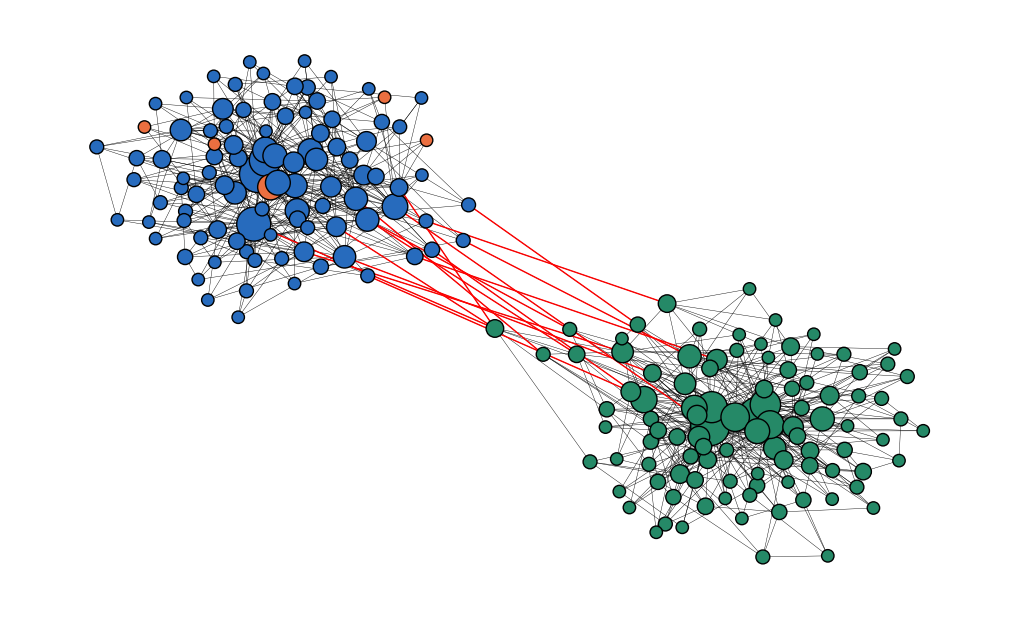

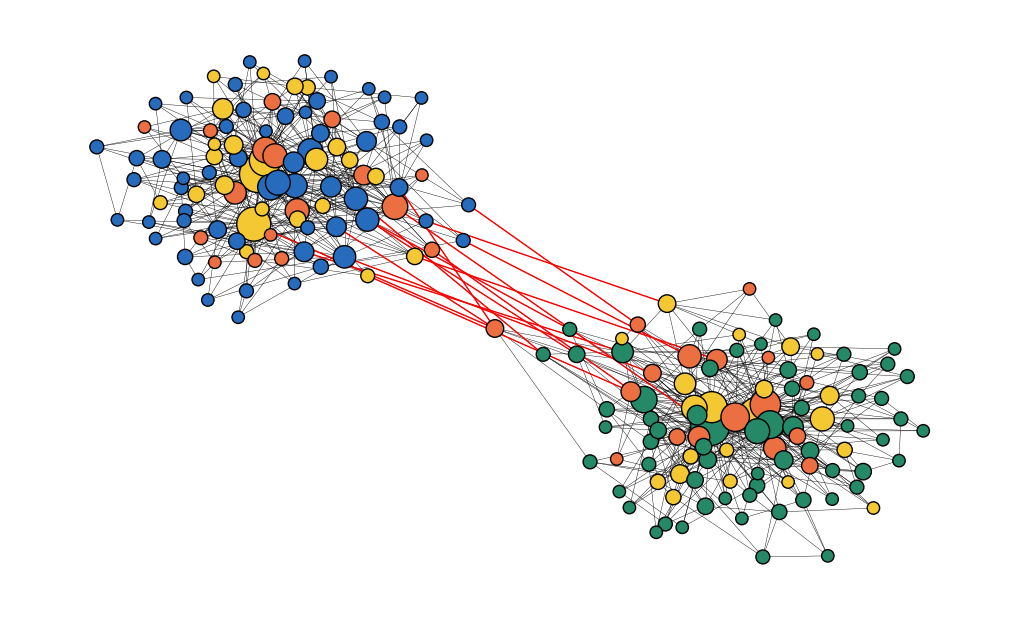

In [6]:
Model().run_simulation()